In [1]:
import torch

import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
from PIL import Image
from easyfsl.data_tools import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [2]:
image_size = 224
 

train_tranform = transforms.Compose(
        [
            # transforms.Grayscale(num_output_channels=2),
            transforms.RandomResizedCrop(image_size),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
            

test_tranform =transform=transforms.Compose(
        [
           
            # transforms.Grayscale(num_output_channels=2),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            # transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    )
   
   
    

In [3]:
inp_image = Image.open("D:\Cataract_project\Cataract_Project\labelled_data\Cataract_11.jpeg")
input_tensor = test_tranform(inp_image)
inp_batch = input_tensor.unsqueeze(0)

In [4]:
train_set = torchvision.datasets.ImageFolder(root="few_shot_data - Copy//train/", transform = train_tranform)

In [5]:
train_set

Dataset ImageFolder
    Number of datapoints: 26
    Root location: few_shot_data - Copy//train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
           )

In [6]:
test_set = torchvision.datasets.ImageFolder(root= "few_shot_data - Copy//val/", transform = test_tranform)

In [7]:
test_set

Dataset ImageFolder
    Number of datapoints: 177
    Root location: few_shot_data - Copy//val/
    StandardTransform
Transform: Compose(
               Resize(size=[257, 257], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [8]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
N_WAY = 2# Number of classes in a task
N_SHOT = 10 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
test_set.labels = [i[1] for i in test_set.imgs]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=1,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


In [10]:
type(test_set)

torchvision.datasets.folder.ImageFolder

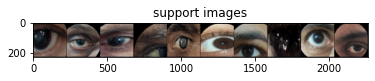

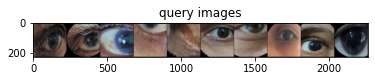

In [14]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)


In [12]:
model.eval()
example_scores = model(
    example_support_images,
    example_support_labels,
    example_query_images,
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.classes[example_class_ids[example_query_labels[i]]]} / {test_set.classes[example_class_ids[example_predicted_labels[i]]]}"
    )


Ground Truth / Predicted
cataract / cataract
cataract / normal
cataract / cataract
cataract / normal
cataract / cataract
cataract / cataract
cataract / normal
cataract / cataract
cataract / normal
cataract / normal
normal / normal
normal / normal
normal / normal
normal / cataract
normal / normal
normal / normal
normal / normal
normal / normal
normal / normal
normal / normal


In [12]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images, support_labels, query_images)
            .detach()
            .data,
            1,
        )[1]
        == query_labels
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


# evaluate(test_loader)


In [13]:
N_TRAINING_EPISODES = 2000
N_VALIDATION_TASKS = 100

train_set.labels = [instance[1] for instance in train_set.imgs]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=5, n_query=5, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=1,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images, support_labels, query_images
    )

    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

In [22]:
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|███████████████████████████████████████████████████████████████| 2000/2000 [1:32:36<00:00,  2.78s/it, loss=0.0206]


In [26]:
evaluate(test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:59<00:00,  2.39s/it]

Model tested on 100 tasks. Accuracy: 57.55%


In [23]:
torch.save(model.state_dict(),'5_shot.pth')

In [41]:
model.load_state_dict(torch.load('few_shot_classifier_10shot.pth',map_location={'cuda:0': 'cpu'}))

<All keys matched successfully>

In [13]:
with torch.no_grad():
    output = evaluate(test_loader)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.29s/it]

Model tested on 100 tasks. Accuracy: 78.50%


In [ ]:
type(model)

In [ ]:
type(example_support_images)

In [16]:
rd_set = torchvision.datasets.ImageFolder(root= r"D:\Cataract_data\eye_image\Final\train", transform = test_tranform)

In [ ]:
rd_set.imgs[0][1]

In [17]:
N_WAY = 2# Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
rd_set.labels = [i[1] for i in rd_set.imgs]
rd_sampler = TaskSampler(
    rd_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

rd_loader = DataLoader(
    rd_set,
    batch_sampler=rd_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=rd_sampler.episodic_collate_fn,
)


In [ ]:
type(rd_loader)

In [18]:
evaluate(rd_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]

Model tested on 100 tasks. Accuracy: 88.00%


In [ ]:
rd_sampler

In [ ]:
import torch.onnx
torch.onnx.export(model( example_support_images,
    example_support_labels,
    example_query_images),
    
    example_support_images,
    example_support_labels,
    example_query_images,
                  "resnet18.onnx",
                  
                  opset_version=10)

In [ ]:
input_tensor = test_tranform(inp_image)
inp_batch = input_tensor.unsqueeze(0)

In [ ]:
inp_batch

In [ ]:
img_loader = DataLoader(input_tensor)

In [ ]:
type(img_loader)

In [ ]:
evaluate(img_loader)

In [ ]:
input_tensor.imgs

In [ ]:
type(rd_sampler)

In [ ]:
type(inp_image)

In [ ]:
inp_batch

In [ ]:
N_WAY = 2# Number of classes in a task
N_SHOT = 1 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
input_tensor.labels = [i[1] for i in input_tensor.imgs]
ip_sampler = TaskSampler(
    inp_batch, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

rd_loader = DataLoader(
    inp_batch,
    batch_sampler=ip_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=rd_sampler.episodic_collate_fn,
)


In [ ]:
def predict(model,inpt,target,class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(inpt)
        prediction_index = predictions[0].argmax(0)
        predicted = class_mapping[prediction_index]
        expected = class_mapping[target]
        
    return predicted, expected

In [ ]:
inpt, target = input_tensor[0][0], input_tensor[0][1]

In [ ]:
class_mappings = ['Cataract','Normal']

In [ ]:
predicted, expected = predict(model, inpt,target,class_mappings)

In [29]:
model.eval()
# example_scores = model(
#     example_support_images,
#     example_support_labels,
#     inp_batch,
# ).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

# print("Ground Truth / Predicted")
# for i in range(len(example_query_labels)):
#     print(
#         f"{test_set.classes[example_class_ids[example_query_labels[i]]]} / {test_set.classes[example_class_ids[example_predicted_labels[i]]]}"
#     # 
print(example_predicted_labels)

tensor([1])


In [1]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)


NameError: name 'train_loader' is not defined

In [20]:
example_query_images

tensor([[[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0078,  ..., 0

In [19]:
?inp_batch

Type:        Tensor
String form:
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.00 <...> .., 0.0000, 0.0039, 0.0039],
           [0.0039, 0.0078, 0.0078,  ..., 0.0000, 0.0039, 0.0039]]]])
Length:      1
File:        c:\users\owais\appdata\local\programs\python\python38\lib\site-packages\torch\__init__.py
Docstring:   <no docstring>


In [ ]:
inp_image = Image.open("D:\Cataract_project\Cataract_Project\labelled_data\Cataract_11.jpeg")
input_tensor = test_tranform(inp_image)
inp_batch = input_tensor.unsqueeze(0)

In [27]:
def transform_image(path):
    import io
    from prep_image_module import prep_img
    import cv2
    import matplotlib.pyplot as plt
    tranform = transforms.Compose(
        [
           
            # transforms.Grayscale(num_output_channels=2),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    )
    # image  = Image.open(path)
    image = prep_img(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image)
    pil_image.show()
    # image = Image.open(io.BytesIO(image_bytes))
    image_tensor = tranform(pil_image).unsqueeze(0)
    
    return image_tensor
    

In [61]:
transform_image(r"D:\Cataract_project\Cataract_Project\labelled_data\Cataract_11.jpeg")

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [ ]:
model.eval()
# example_scores = model(
#     example_support_images,
#     example_support_labels,
#     inp_batch,
# ).detach()
example_scores = model(  example_support_images,  example_support_labels,inp_batch).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)

# print("Ground Truth / Predicted")
# for i in range(len(example_query_labels)):
#     print(
#         f"{test_set.classes[example_class_ids[example_query_labels[i]]]} / {test_set.classes[example_class_ids[example_predicted_labels[i]]]}"
#     # 
print(example_predicted_labels[1])

In [28]:
def prediction(image_tensor):
    example_scores = model(  example_support_images,  example_support_labels,image_tensor).detach()
    _, example_predicted_labels = torch.max(example_scores.data, 1)
    return example_predicted_labels
    # return "Normal" if example_predicted_labels==1 else "Cataract"
    

In [38]:
prediction(transform_image(r"D:\Cataract_project\Cataract_Project\labelled_data\Cataract_11.jpeg"))

tensor([0])

In [30]:
prediction(transform_image(r"C:\Users\owais\Desktop\4a99c083-f096-4f7d-b0c5-608fd509241f.jpg"))

tensor([1])

In [31]:
prediction(transform_image(r"D:\Cataract_data\eyesonly\cataract\20220223_143640.jpg"))

tensor([1])

In [32]:
prediction(transform_image(r"D:\Cataract_project\Cataract_Project\data_splitted\test\cataract\severe_27.png"))

tensor([0])

In [33]:
prediction(transform_image(r"D:\Cataract_project\Cataract_Project\data_splitted\test\cataract\20220223_143412.jpg"))

tensor([1])

In [34]:
prediction(transform_image(r"D:\Downloads\621526ee-29ca-47ff-9a7e-871f56152813.jpg"))

tensor([1])

In [37]:
prediction(transform_image(r"D:\Downloads\IMG-3532.jpg"))

tensor([1])